In [1]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all' #默认为'last'
%config IPCompleter.greedy=True

In [2]:
import sys
import os
import time
import pandas as pd
import numpy as np
import warnings
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score
import seaborn as sns

sys.path.append('/Users/yantingting/PycharmProjects/modeling')
sys.setrecursionlimit(100000)
import plot_tools as pl
import metrics
import summary_statistics as ss
import feature_selection as fs
from data_io_utils import *
import data_processing as dp


In [3]:
file_path_in = '/Users/yantingting/Documents/海外风控/巴西/拼接数据&模型初版/'
file_path_model = '/Users/yantingting/Documents/海外风控/巴西/模型初版_SDK_temp/'

In [4]:
drop_list = ['Santander', 'disk_size','OLX', 'high_freq_app','Mercado Livre', 'Snaptube', 'Way']

In [5]:
df_var = pd.read_csv(file_path_in + 'df_var.csv')
df_var = df_var.drop(drop_list, axis = 1)
df_var.shape
df_train1= df_var[df_var['is_sample'] == 1]
df_train1['flag_result'].shape
df_train2= df_var[df_var['is_sample'] == 2]
df_train2['flag_result'].shape
df_test= df_var[df_var['is_sample'] == 3]
df_test['flag_result'].shape
df_var.head()


(23927, 48)

(14969,)

(3743,)

(5215,)

,loan_id,DATE,flag_result,is_sample,var17,var18,var36,var2-O,var3-0,var10-Assalariados,...,PagSeguro,Serasa,Smart Tutor,Spotify,Uber,Waze,WhatsApp,Wish,available_memory_size,total_memory_size
0,3808870852,20191014,1,1,-1.0,623.0,0.0,1,1,1,...,0.0,0.015324,0.000000,0.0,0.000000,0.000000,0.000276,0.0,464.00,1863.68
1,3808871384,20191015,1,1,-1.0,489.0,0.0,1,1,1,...,0.0,0.000000,0.036056,0.0,0.000000,0.000000,0.000494,0.0,367.00,1955.84
2,3808917409,20191017,1,1,-1.0,693.0,0.0,1,1,0,...,0.0,0.011766,0.000000,0.0,0.007510,0.000000,0.000212,0.0,314.00,1935.36
3,3808927120,20191018,1,1,624.0,-1.0,0.0,1,1,1,...,0.0,0.000000,0.000000,0.0,0.007935,0.000000,0.000224,0.0,790.00,4003.84
4,3808927373,20191018,1,2,-1.0,553.0,0.0,0,0,1,...,0.0,0.010137,0.000000,0.0,0.000000,0.013264,0.000182,0.0,1044.48,6051.84


In [6]:
df_var = df_var.fillna(-1)
X_train1 = df_train1.iloc[:, 4:]
y_train1 = df_train1['flag_result'].astype(int)
X_train2 = df_train2.iloc[:, 4:]
y_train2 =df_train2['flag_result'].astype(int)
X_test = df_test.iloc[:, 4:]
y_test = df_test['flag_result'].astype(int)

In [7]:
'''
step2 训练模型，初筛变量
'''
model = XGBClassifier()
eval_set = [(X_train2, y_train2)]
model.fit( X_train1,  y_train1,  early_stopping_rounds=10,  eval_metric="auc",  eval_set=eval_set,  verbose=False)
y2_pred = model.predict(X_train2)
predictions = [round(value) for value in y2_pred]
accuracy = accuracy_score(y_train2, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


'\nstep2 训练模型，初筛变量\n'

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Accuracy: 91.64%


In [8]:
all_features = list(X_train1.columns)
feature_importance = model.feature_importances_
features_in_model = all_features
features_in_model = [all_features[i] for i in range(len(feature_importance)) if feature_importance[i] > 0]

In [9]:
# 创建新的dataframe存储变量的重要性
var_importance = pd.DataFrame(columns=["var_name", 'importance'])
var_importance['var_name'] = all_features
var_importance['importance'] = feature_importance
var_importance.sort_values('importance',  ascending=False).to_csv(file_path_model + 'var_importance.csv')
var_importance.sort_values('importance',  ascending=False).head(10)


,var_name,importance
11,var22-APROVA,0.602391
6,var10-Autonomos,0.057557
3,var2-O,0.034241
13,var31-NAO_CONSTAM_OCORRENCIAS,0.029076
0,var17,0.026302
1,var18,0.026148
9,var21-FALHA,0.024473
10,var25-1.0,0.020872
40,WhatsApp,0.020070
5,var10-Assalariados,0.019551


In [10]:
var_dict = pd.read_csv(file_path_in + 'var_dict.csv')
var_dict = var_dict[~var_dict['指标英文'].isin(drop_list)]
# var_dict['指标英文'].tolist()

In [11]:
'''
# 计算PSI  IV
'''
time1 = time.time()
args_dict = {
    'random_forest': {
    'grid_search': False,  # 选择了True则会进行网格筛选速度会比较慢
    'param': None
    },
    'xgboost': {
    'grid_search': False,
    'param': None
    }
}
methods = [
    'random_forest',
    # 'lasso',
    'xgboost'
]

fs_obj = fs.FeatureSelection()
bin_obj = metrics.BinWoe()
model_data_final = df_train1.copy()
features_var_dict = list(var_dict['指标英文'])
X_IV = model_data_final[features_var_dict]
y_IV = model_data_final['flag_result'].astype(int)
X_cat_train, X_transformed, woe_iv_df, rebin_spec, ranking_result = fs_obj.overall_ranking(X_IV, y_IV, var_dict, args_dict, methods, num_max_bins=5)
rebin_spec_bin_adjusted = {k: v for k, v in rebin_spec.items() if k in features_var_dict}
# 输出的是变量的分箱
X_cat_train = bin_obj.convert_to_category( model_data_final[features_var_dict],  var_dict, rebin_spec_bin_adjusted)

model_data_final['appmon'] = model_data_final['DATE'].apply(lambda x: 1 if x > 20191001 else 0)

X_cat_train_with_y_appmon = pd.merge(X_cat_train, model_data_final[['flag_result', 'appmon']], left_index=True,
                                     right_index=True)
var_dist_badRate_by_time = ss.get_badRate_and_dist_by_time(X_cat_train_with_y_appmon, features_var_dict, 'appmon',   'flag_result')
var_dist_badRate_by_time.columns = [
    'varName',
    'bins',
    'total1',
    'tolal2',
    'bad1',
    'bad2',
    'dist1',
    'dist2',
    'badrate1',
    'badrate2']
var_dist_badRate_by_time.to_csv(file_path_model + "var_dist_badRate_by_time.csv", index=False, sep=',')
time2 = time.time()
print('run_time : ', time2 - time1)

'\n# 计算PSI  IV\n'

/Users/yantingting/anaconda3/envs/modeling/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/yantingting/anaconda3/envs/modeling/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/yantingting/anaconda3/envs/modeling/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.936606	test-auc:0.936452
[10]	train-auc:0.950785	test-auc:0.948839
[20]	train-auc:0.952985	test-auc:0.950485
[30]	train-auc:0.956868	test-auc:0.953548
[40]	train-auc:0.958858	test-auc:0.954173
[50]	train-auc:0.960329	test-auc:0.954111
[60]	train-auc:0.961468	test-auc:0.954121
[70]	train-auc:0.96238	test-auc:0.954017
[80]	train-auc:0.964461	test-auc:0.954346
[90]	train-auc:0.966167	test-auc:0.954669
[100]	train-auc:0.967837	test-auc:0.955002
[110]	train-auc:0.969067	test-auc:0.955135
[120]	train-auc:0.970336	test-auc:0.95507
[130]	train-auc:0.971402	test-auc:0.955338
[140]	train-auc:0.972395	test-auc:0.955435
[150]	train-auc:0.97337	test-auc:0.955642
[160]	train-auc:0.9743	test-auc:0.955827
[170]	train-auc:0.975115	test-auc:0.956053
[180]	train-auc:0.976014	test-auc:0.956411
[190]	train-auc:0.976932	test-auc:0.956755
[200]	train-auc:0.977651	test-auc:0.956937
[210]	train-auc:0.978407	test-auc:0.957083
[220]	train-auc:0.979071	test-auc:0.957204
[230]	train-auc:0.97971	tes

In [12]:
var_dist_badRate_by_time_ = pd.read_csv(file_path_model + "var_dist_badRate_by_time.csv")
# CALCULATE PSI
var_dist_badRate_by_time_['PSI'] = (var_dist_badRate_by_time_['dist1'] - var_dist_badRate_by_time_['dist2']) * np.log(
    var_dist_badRate_by_time_['dist1'] / var_dist_badRate_by_time_['dist2'])

var_psi = pd.DataFrame(var_dist_badRate_by_time_.groupby(['varName'])['PSI'].agg(['sum']))
var_psi['varName'] = var_psi.index
var_psi.columns = ['PSI', 'varName']
var_psi = var_psi[[ 'varName' ,  'PSI']]
features_stable = list(var_psi[var_psi['PSI'] <= 0.2]['varName'])
features_unstable = list(var_psi[var_psi['PSI'] > 0.2]['varName'])
features_iv_hi = list(ranking_result[ranking_result['IV'] >= 0.02]['指标英文'])
features_iv_lo = list(ranking_result[ranking_result['IV'] < 0.02]['指标英文'])
var_psi.to_csv(file_path_model + "var_psi.csv", index=False, sep=',')
woe_iv_df.to_csv(file_path_model + "woe_iv_df_.csv", index=False, sep=',')
features_remove = set(features_unstable + features_iv_lo)
features_in_model = [ele for ele in features_in_model if ele not in features_remove]
features =pd.DataFrame({"var": features_in_model})
features['数据源'] = features['var'].map(lambda x: dict(zip(var_dict['指标英文'], var_dict['数据源']))[x])
features = features[features['数据源'] != 'bank']
features_in_model = features['var'].to_list()
features.to_csv(file_path_model + "features_in_model.csv")
features.head()


,var,数据源
10,cnt_app,app_freq
11,BB,app_tfidf
12,Banco Inter,app_tfidf
13,Empréstimo,app_tfidf
14,Empréstimo Pessoal,app_tfidf


In [13]:
'''
-------------------------------
XGB tuning parameters
-------------------------------
'''
'''
参数调优的一般步骤
1. 确定学习速率和提升参数调优的初始值
2. max_depth 和 min_child_weight 参数调优
3. gamma参数调优
4. subsample 和 colsample_bytree 参数优
5. 正则化参数alpha调优
6. 降低学习速率和使用更多的决策树
'''

df_train1_learn = df_train1[features_in_model]
df_train2_learn = df_train2[features_in_model]
X_train1 = df_train1_learn.values
X_train2 = df_train2_learn.values

# best_xgb = XGBClassifier()

param_test1 = {
    'max_depth': range(3, 10, 1),
    'min_child_weight': range(1, 6, 1)
}
gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=90, gamma=0, subsample=0.7,
                                                max_depth=4, colsample_bytree=1, objective='binary:logistic',
                                                nthread=6, scale_pos_weight=1, seed=27),
                        param_grid=param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)

gsearch1.fit(X_train1, y_train1)

best_max_depth = gsearch1.best_params_['max_depth']
best_min_child_weight = gsearch1.best_params_['min_child_weight']
print('1:', gsearch1.best_score_)

param_test2 = {'gamma': [i / 10.0 for i in range(0, 5)]}
gsearch2 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=90, subsample=0.7, colsample_bytree=1,
                                                max_depth=best_max_depth,
                                                min_child_weight=best_min_child_weight, objective='binary:logistic',
                                                nthread=6, scale_pos_weight=1, seed=27),
                        param_grid=param_test2, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch2.fit(X_train1, y_train1)
best_gamma = gsearch2.best_params_['gamma']
print('2:', gsearch2.best_score_)


param_test3 = {
    'subsample': [i / 10.0 for i in range(6, 10)],
    'colsample_bytree': [i / 10.0 for i in range(6, 10)]
}
gsearch3 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=90, max_depth=best_max_depth, gamma=best_gamma,
                                                min_child_weight=best_min_child_weight, objective='binary:logistic', nthread=6,
                                                scale_pos_weight=1, seed=27),
                        param_grid=param_test3, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch3.fit(X_train1, y_train1)
best_subsample = gsearch3.best_params_['subsample']
best_colsample_bytree = gsearch3.best_params_['colsample_bytree']
print('3:', gsearch3.best_score_)


param_test4 = {'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]}
gsearch4 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=90, max_depth=best_max_depth, gamma=best_gamma,
                                                colsample_bytree=best_colsample_bytree, subsample=best_subsample,
                                                min_child_weight=best_min_child_weight, objective='binary:logistic', nthread=6,
                                                scale_pos_weight=1, seed=27),
                        param_grid=param_test4, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch4.fit(X_train1, y_train1)
best_reg_alpha = gsearch4.best_params_['reg_alpha']
print('4:', gsearch4.best_score_)


param_test5 = {'n_estimators': range(50, 500, 20)}
gsearch5 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, max_depth=best_max_depth, gamma=best_gamma,
                                                colsample_bytree=best_colsample_bytree, subsample=best_subsample,
                                                reg_alpha=best_reg_alpha,
                                                min_child_weight=best_min_child_weight, objective='binary:logistic',
                                                nthread=6, scale_pos_weight=1, seed=27),
                        param_grid=param_test5, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch5.fit(X_train1, y_train1)
best_n_estimators = gsearch5.best_params_['n_estimators']
print('5:', gsearch5.best_score_)


param_test6 = {'learning_rate': [i / 100.0 for i in range(0, 30)]}
gsearch6 = GridSearchCV(estimator=XGBClassifier(max_depth=best_max_depth, gamma=best_gamma, n_estimators=best_n_estimators,
                                                colsample_bytree=best_colsample_bytree, subsample=best_subsample, reg_alpha=best_reg_alpha,
                                                min_child_weight=best_min_child_weight, objective='binary:logistic', nthread=6,
                                                scale_pos_weight=1, seed=27),
                        param_grid=param_test6, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch6.fit(X_train1, y_train1)
best_learning_rate = gsearch6.best_params_['learning_rate']
print('6:', gsearch6.best_score_)

# 用获取得到的最优参数再次训练模型
best_xgb = XGBClassifier(learning_rate=best_learning_rate, n_estimators=best_n_estimators, max_depth=best_max_depth,
                         gamma=best_gamma, colsample_bytree=best_colsample_bytree, subsample=best_subsample, reg_alpha=best_reg_alpha,
                         min_child_weight=best_min_child_weight,
                         objective='binary:logistic', nthread=6, scale_pos_weight=1, eval_metric='auc', seed=27)
print(best_xgb)
best_xgb.fit(X_train1, y_train1)
print('process is end!')


'\n-------------------------------\nXGB tuning parameters\n-------------------------------\n'

'\n参数调优的一般步骤\n1. 确定学习速率和提升参数调优的初始值\n2. max_depth 和 min_child_weight 参数调优\n3. gamma参数调优\n4. subsample 和 colsample_bytree 参数优\n5. 正则化参数alpha调优\n6. 降低学习速率和使用更多的决策树\n'

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=1,
                                     missing=None, n_estimators=90, n_jobs=1,
                                     nthread=6, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.7, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'max_depth': range(3, 10),
                         'min_child_weight': range(1, 6)},
             pre_dispatch='2*n_jobs', refit=True, return_train_s

1: 0.5483949707300185


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=4,
                                     missing=None, n_estimators=90, n_jobs=1,
                                     nthread=6, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.7, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbo

2: 0.5488450383312308


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0.3,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=4,
                                     missing=None, n_estimators=90, n_jobs=1,
                                     nthread=6, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=1, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             pre_dispatch='2*n_jobs', refit=Tru

3: 0.5504346653256326


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0.3,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=4,
                                     missing=None, n_estimators=90, n_jobs=1,
                                     nthread=6, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.6, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc

4: 0.5504346653256326


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0.3,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=4,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=6, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.6, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'n_estimators': range(50, 500, 20)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', 

5: 0.5569100349912476


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0.3,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=4,
                                     missing=None, n_estimators=50, n_jobs=1,
                                     nthread=6, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_l...
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.6, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'learning_rate': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05,
                                           0.06, 0.07, 0.08, 0.09, 0.1, 0.11,
                    

6: 0.5596370889555164
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='auc',
              gamma=0.3, learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=4, missing=None, n_estimators=50, n_jobs=1,
              nthread=6, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.6, verbosity=1)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='auc',
              gamma=0.3, learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=4, missing=None, n_estimators=50, n_jobs=1,
              nthread=6, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.6, verbosity=1)

process is end!


In [14]:
def Prob2Score(prob, basePoint, PDO):
    y = np.log(prob / (1 - prob))
    return (basePoint + PDO / np.log(2) * (-y)).astype(int)

In [15]:
'''
-------------------------------
Model scoring
-------------------------------
'''
df_all_learn = df_var[features_in_model]
X_df_all = df_all_learn.values
y_df_all = df_var['flag_result'].astype(int)
y_df_all_pred = best_xgb.predict_proba(X_df_all)[:, 1]

score_all = [round(Prob2Score(value, 600, 20)) for value in y_df_all_pred]
predictions = [round(value) for value in y_df_all_pred]
mylist = ['loan_id', 'flag_result', 'DATE']
# SettingWithCopyWarning出现的原因  链式赋值/Chained Assignment  所以在后边加一个copy()
df_all_result = df_var[mylist].copy()
df_all_result.loc[:, 'predictions'] = predictions
df_all_result.loc[:, 'y_df_pred'] = y_df_all_pred
df_all_result.loc[:, 'score_all'] = score_all
df_all_result.loc[:, 'group'] = pd.qcut(pd.DataFrame(
    score_all)[0], q=10, duplicates='drop', precision=0).astype(str)
df_all_result.to_csv(file_path_model + "df_all_result.csv")
accuracy = accuracy_score(y_df_all, predictions)
print("AccuracyAll: %.2f%%" % (accuracy * 100.0))



'\n-------------------------------\nModel scoring\n-------------------------------\n'

AccuracyAll: 87.83%


In [16]:

'''
-------------------------------
Model evaluation
-------------------------------
'''

df_train1_result = pd.merge(df_train1[['loan_id']], df_all_result, on='loan_id', how='left' )
df_train2_result = pd.merge(df_train2[['loan_id']], df_all_result, on='loan_id', how='left' )
df_test_result = pd.merge(df_test[['loan_id']], df_all_result, on='loan_id', how='left' )

# AUC+Accuracy
train1_auc = roc_auc_score(df_train1_result['flag_result'], df_train1_result['y_df_pred'])
print("train1_auc: %.2f" % train1_auc)
train2_auc = roc_auc_score(df_train2_result['flag_result'], df_train2_result['y_df_pred'])
print("train2_auc: %.2f" % train1_auc)
test_auc = roc_auc_score(df_test_result['flag_result'], df_test_result['y_df_pred'])
print("test_auc: %.2f" % test_auc)
train1_accuracy = accuracy_score(
    df_train1_result['flag_result'],
    df_train1_result['predictions'])
print("train1_accuracy: %.2f%%" % (train1_accuracy * 100.0))
train2_accuracy = accuracy_score(
    df_train2_result['flag_result'],
    df_train2_result['predictions'])
print("train2_accuracy: %.2f%%" % (train2_accuracy * 100.0))
test_accuracy = accuracy_score(
    df_test_result['flag_result'],
    df_test_result['predictions'])
print("test_accuracy: %.2f%%" % (test_accuracy * 100.0))

# KS
def ModelBin(data):
    bad = data['flag_result'].sum()
    good = data['flag_result'].count() - bad
    df = data.groupby(data['group'])
    df1 = pd.DataFrame()
    df1['total'] = df["flag_result"].count()
    df1['bad'] = df["flag_result"].sum()
    df1['good'] = df1['total'] - df1["bad"]
    df1['per%'] = df1['total'] / data['flag_result'].count()
    df1['overdue'] = df1['bad'] / df1['total']
    df1['cum_bad'] = df1['bad'].cumsum(0) / bad
    df1['cum_good'] = df1['good'].cumsum(0) / good
    df1["KS"] = df1['cum_bad'] - df1['cum_good']
    df1["cum_overdue"] = df1["bad"].cumsum(0) / df1['total'].cumsum(0)

    df1.columns = ["total", "bad", "good", "per%", "overdue",
                   "cum_bad", "cum_good", "KS", "cum_overdue"]
    return df1


writer = pd.ExcelWriter(file_path_model + "result.xlsx")
ModelBin(df_train1_result).to_excel(writer, sheet_name="train1")
ModelBin(df_train2_result).to_excel(writer, sheet_name="train2")
ModelBin(df_test_result).to_excel(writer, sheet_name="test")
writer.save()

'''
-------------------------------
SAVE MODEL
-------------------------------
'''
best_xgb.save_model(file_path_model + 'bx_sdk_model.model')


'\n-------------------------------\nModel evaluation\n-------------------------------\n'

train1_auc: 0.60
train2_auc: 0.60
test_auc: 0.58
train1_accuracy: 87.27%
train2_accuracy: 87.74%
test_accuracy: 89.51%


'\n-------------------------------\nSAVE MODEL\n-------------------------------\n'

In [19]:
feature = pd.read_csv(file_path_model + "features_in_model.csv")
feature.shape
feature_list = feature['var'].tolist()
final_importance = best_xgb.feature_importances_
#存储模型最终的变量重要性
var_importance = pd.DataFrame(columns=["var_name", 'importance'])
var_importance['var_name'] = feature_list
var_importance['importance'] = final_importance
var_importance = var_importance.sort_values('importance',  ascending=False)
var_importance

(17, 3)

,var_name,importance
0,cnt_app,0.123464
4,Empréstimo Pessoal,0.106137
15,WhatsApp,0.079015
6,Itaucard,0.066132
14,Uber,0.066117
10,Meu Vivo,0.065258
11,PagSeguro,0.056569
7,Itaú,0.054565
9,Messenger,0.052953
12,Serasa,0.045692


In [18]:
mymodel = xgb.Booster() 
mymodel.load_model('/Users/yantingting/Documents/海外风控/巴西/模型初版_SDK(1)/bx_sdk_model.model')
feature = pd.read_csv(file_path_model + "features_in_model.csv")
feature.shape
feature_list = feature['var'].tolist()
final_importance = mymodel.feature_importances_
#存储模型最终的变量重要性
var_importance = pd.DataFrame(columns=["var_name", 'importance'])
var_importance['var_name'] = feature_list
var_importance['importance'] = final_importance
var_importance = var_importance.sort_values('importance',  ascending=False)
var_importance.head(10)

(17, 3)

AttributeError: 'Booster' object has no attribute 'feature_importances_'

# 画图

(17, 3)

0    16347
1     2365
Name: flag_result, dtype: int64

0    13063
1     1906
Name: flag_result, dtype: int64

0    3284
1     459
Name: flag_result, dtype: int64

cnt_app is in processing




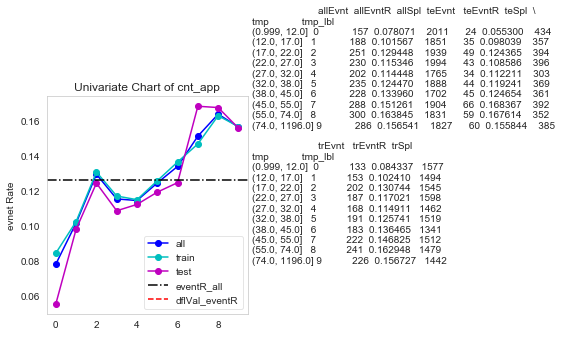

BB is in processing




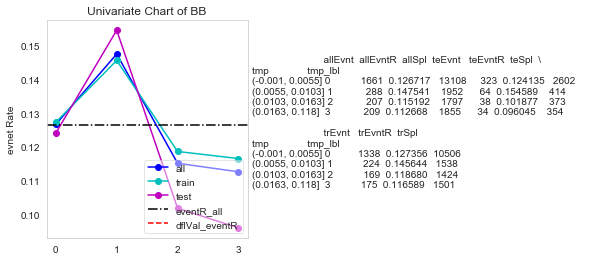

Banco Inter is in processing




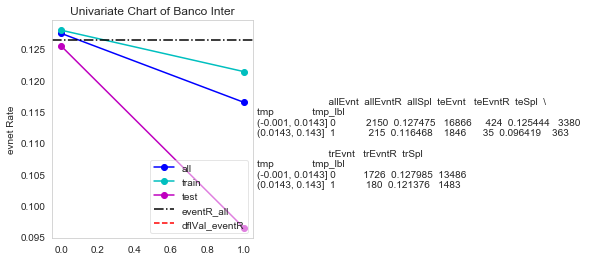

Empréstimo is in processing




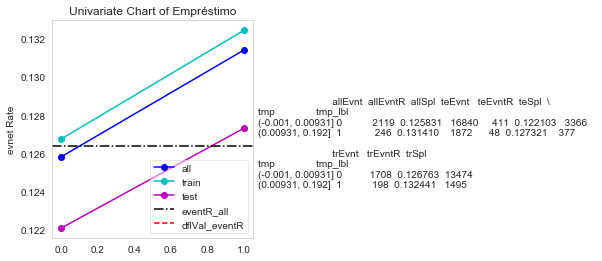

Empréstimo Pessoal is in processing




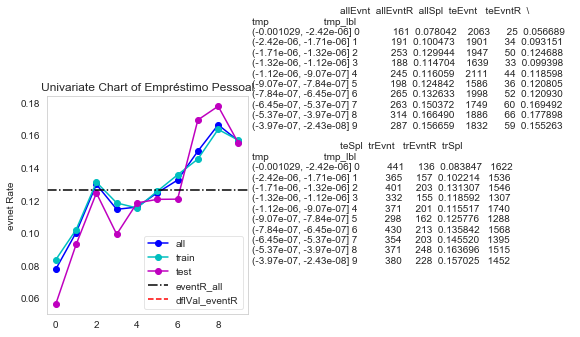

Google Play Games is in processing




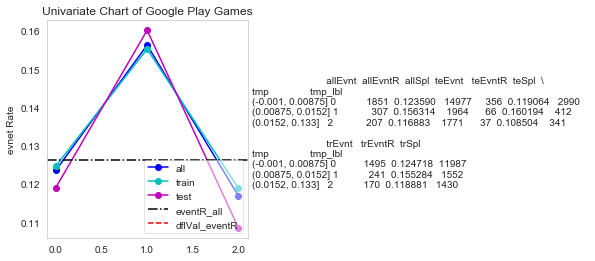

Itaucard is in processing




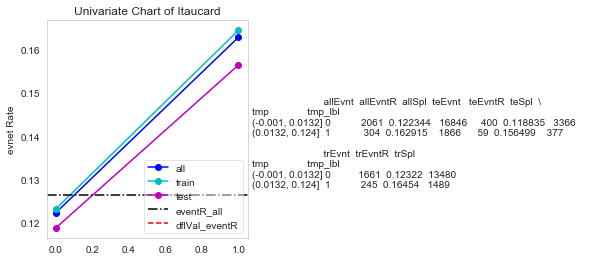

Itaú is in processing




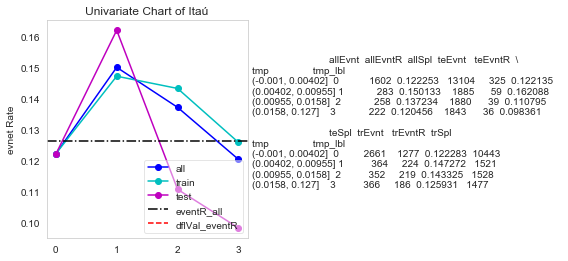

Mercado Pago is in processing




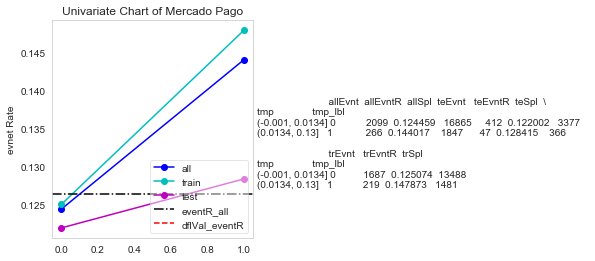

Messenger is in processing




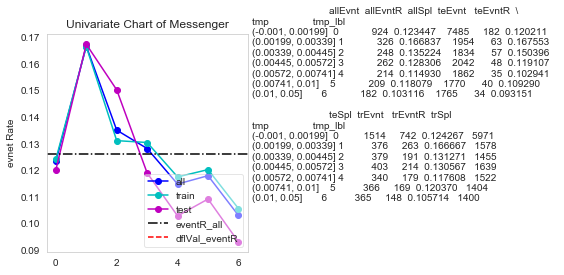

Meu Vivo is in processing




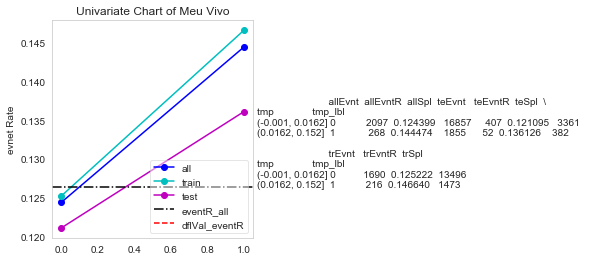

PagSeguro is in processing




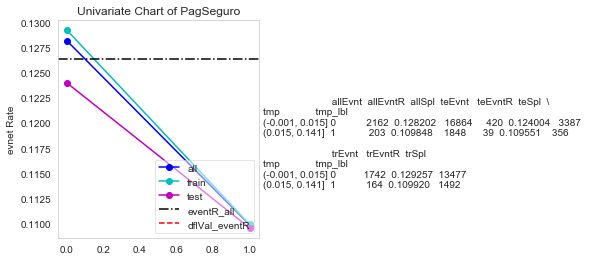

Serasa is in processing




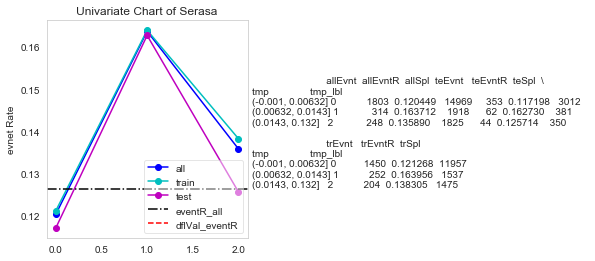

Spotify is in processing




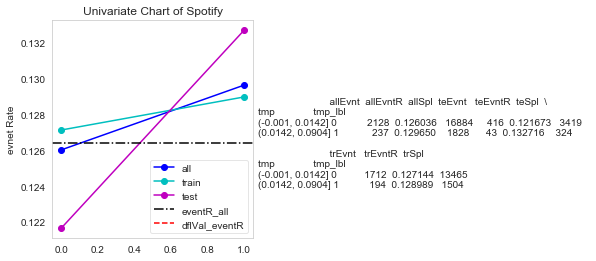

Uber is in processing




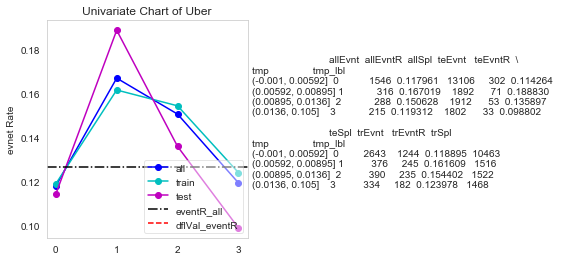

WhatsApp is in processing




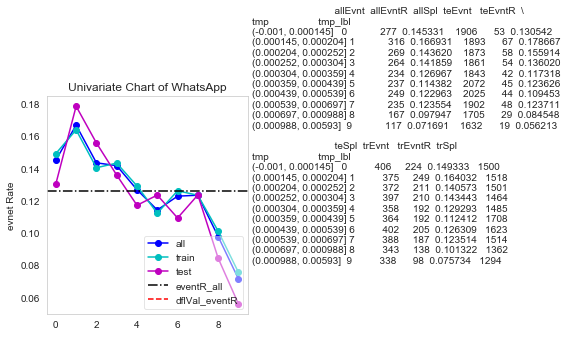

Wish is in processing




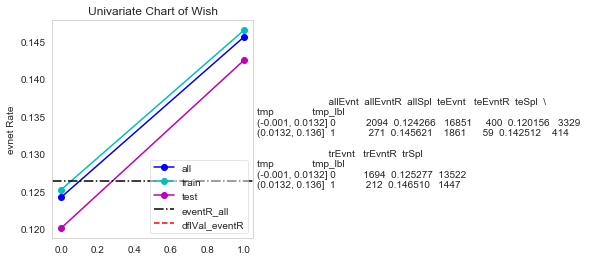

[]
run_time:  11.747116804122925


In [20]:
feature = pd.read_csv(file_path_model + "features_in_model.csv")
feature.shape
feature_list = feature['var'].tolist()
time1 = time.time()
df_train1_train2 = df_var[(df_var['is_sample'] == 1)|(df_var['is_sample'] == 2)]
df_train1_train2['flag_result'].value_counts()
df_train1 = df_var[df_var['is_sample'] == 1]
df_train1['flag_result'].value_counts()
df_train2 = df_var[df_var['is_sample'] == 2]
df_train2['flag_result'].value_counts()
wrong_list= []
for col in feature_list:
    print('{} is in processing'.format(col))
    try:
        pl.uniVarChart(df_train1_train2.fillna(-1),  col, target = 'flag_result', n_bins = 10, result_path=file_path_model ,dfltValue = -1, dftrain =df_train1.fillna(-1), dftest = df_train2.fillna(-1), 
                drawAll = True, drawTrTe = True)
    except IndexError:
        wrong_list.append(col)
        print('wrong!')
print(wrong_list)
time2 = time.time()
print('run_time: ', time2-time1)
            

In [21]:
# mymodel = xgb.Booster()
# model1 = mymodel.load_model(file_path_model + 'bx_sdk_model.model')

sys.path.append('/Users/yantingting/Documents/newgenie/newgenie')
var_importance= pd.read_csv(file_path_model + 'var_importance.csv', usecols=[1,2])
feature = pd.read_csv(file_path_model + "features_in_model.csv")
model_importance = pd.merge(feature[['var']], var_importance, left_on = 'var', right_on = 'var_name', how='left')
model_importance = model_importance.drop('var_name', axis = 1)
# model_importance.head()
test_pred = pd.concat([df_train1.iloc[:, 4:], df_train2.iloc[:, 4:]], axis =0)
model = xgb.Booster()
model.load_model(file_path_model + 'bx_sdk_model.model')
model_importance.head()
model_importance.columns = ['varName', 'importance']                       
import utils3.generate_report as gr
f_imp_list = gr.get_feature_importance(model_importance)
import utils3.plot_tools as pt
import matplotlib.pyplot as plt
RESULT_PATH = file_path_model
FIG_PATH = os.path.join(RESULT_PATH, 'figure', 'PDP')
if not os.path.exists(FIG_PATH):
    os.makedirs(FIG_PATH)

n=0
while n <len(f_imp_list):
    m = n+9
    features_draw=[i for i in f_imp_list[n:m]]
    select_features = model_importance['varName'].values.tolist()
    pt.pdpCharts9(model, test_pred, features_draw, select_features, n_bins=10, dfltValue = -1)
    path = os.path.join(FIG_PATH,"pdp_"+str(n)+"_"+str(m)+".png")
    plt.savefig(path, format='png', dpi=100)
    plt.close()
    n += 9
    
print('end!')

,var,importance
0,cnt_app,0.001699
1,BB,0.011454
2,Banco Inter,0.007354
3,Empréstimo,0.007698
4,Empréstimo Pessoal,0.000101


[<Figure size 1152x576 with 9 Axes>]

[<Figure size 1152x576 with 8 Axes>]

end!


<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

In [22]:
from sklearn import metrics
from matplotlib.pylab import rcParams
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from sklearn import metrics
from matplotlib.pylab import rcParams
from sklearn.externals import joblib
import platform
import sklearn
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
rcParams['figure.figsize'] = 16,8

def calc_rate(df, y_true):
    return pd.DataFrame.from_dict(
        {
            'cntLoan': len(df),
            'event': df[y_true].sum(),
            'eventRate': df[y_true].mean()
        },
        orient='index').T


def show_result_new(df, y_pred, y_true, n_bins, feature_label='', result_path = None):
    '''
    模型预测结果的Lift Chart.

    :param df: 数据集, DataFrame.
    :param y_pred: 模型预测分数, str.
    :param y_true: 是否违约标签列, array[0, 1].
    :param n_bins: 分箱数量, int.
    :param feature_label:
    :return: Lift Chart, fone
    '''

    if feature_label == '':
        feature_label = y_pred
    df['bkl_%s' % y_pred] = pd.qcut(df[y_pred], n_bins, duplicates='drop')
    n_bins = len(df['bkl_%s' % y_pred].unique())
    print('分箱数量: ', n_bins)

    g_df = df.groupby('bkl_%s' % y_pred).apply(lambda x: calc_rate(x, y_true)).reset_index(level=1, drop=True)
    g_df['acmLoan'] = g_df['cntLoan'].cumsum()
    g_df['acmEvent'] = g_df['event'].cumsum()
    g_df['acmEventRate'] = g_df['acmEvent'] / g_df['acmLoan']
    g_df = g_df.reset_index()
    #print(g_df)
    # plot lift_chart - marginal
    plt.subplot(1, 2, 1)

    g_df.index = range(1, n_bins + 1)
    plt.plot(g_df.index, g_df['eventRate'], marker='o',
             label='Auc of %s:%d:%.3f' % (
                 feature_label, df.shape[0], np.round(metrics.roc_auc_score(df[y_true], df[y_pred]), 3)))  # linestyle='--'
    plt.title('EventRate in %d Quantiles' % n_bins)
    plt.ylabel('eventRate')
    plt.grid(True)
    plt.legend(fontsize=13, loc=2, framealpha=0.5)


    plt.subplot(1, 2, 2)
    plt.plot(g_df.index, g_df['acmEventRate'], marker='o',
             label='Auc of %s:%d:%.3f' % (
                 feature_label, df.shape[0], np.round(metrics.roc_auc_score(df[y_true], df[y_pred]), 3)))  # linestyle='--'
    plt.title('Accum-EventRate in %d Quantiles' % n_bins)
    plt.ylabel('accumEventRate')
    plt.grid(True)
    plt.legend(fontsize=13, loc=2, framealpha=0.5)
    rcParams['figure.figsize'] = 16, 8
    plt.tight_layout()
    if result_path is not None:
        result_path = os.path.join(result_path, 'figure/liftChart/')
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    plt.savefig(os.path.join(result_path, 'lift_chart_overall.png'), format='png', dpi=80)
    plt.show()
    return g_df

In [23]:
sys.path.append('/Users/yantingting/Documents/newgenie/newgenie')
import plot_tools as pt
import matplotlib.pyplot as plt
df_all_result = pd.read_csv(file_path_model + "df_all_result.csv")
df_train1_result = pd.merge(df_train1[['loan_id']], df_all_result, on='loan_id', how='left' )
df_train2_result = pd.merge(df_train2[['loan_id']], df_all_result, on='loan_id', how='left' )
df_test_result = pd.merge(df_test[['loan_id']], df_all_result, on='loan_id', how='left' )
train_pred = df_train1_result
test_pred = df_train2_result
testnew_pred= df_test_result
result_path = file_path_model
train_lc = show_result_new(train_pred, 'y_df_pred','flag_result', n_bins = 10, result_path = result_path, feature_label='train')
test_lc = show_result_new(test_pred, 'y_df_pred','flag_result', n_bins = 10, result_path = result_path, feature_label='test')
oot_lc = show_result_new(testnew_pred, 'y_df_pred','flag_result', n_bins = 10, result_path = result_path, feature_label='OOT')
plt.show()
plt.savefig('lift_chart_overall.png', dpi=100)
plt.close()


分箱数量:  10
分箱数量:  10
分箱数量:  10


In [24]:
import datetime
feature = pd.read_csv(file_path_model + "features_in_model.csv")
feature.shape
feature_list = feature['var'].tolist()
df_var = pd.read_csv(file_path_in + 'df_var.csv')
df_var.shape
df_var['week'] = df_var['DATE'].apply(lambda x: datetime.datetime.strptime(str(x),'%Y%m%d').strftime('%W'))
group = df_var.groupby('week')
fram1 = pd.DataFrame()
fram1['day1'] = group['DATE'].min()
frame1 = fram1.reset_index()
week_dict = dict(zip(frame1['week'],frame1['day1'] ))
df_var['day1']= df_var['week'].apply(lambda x: week_dict[x]) 

(17, 3)

(23927, 55)

<Figure size 1152x576 with 0 Axes>

1


(0, 0.3)

2


(0, 0.3)

3


(0, 0.3)

Text(0.5, 1.0, 'passrate_by_time')

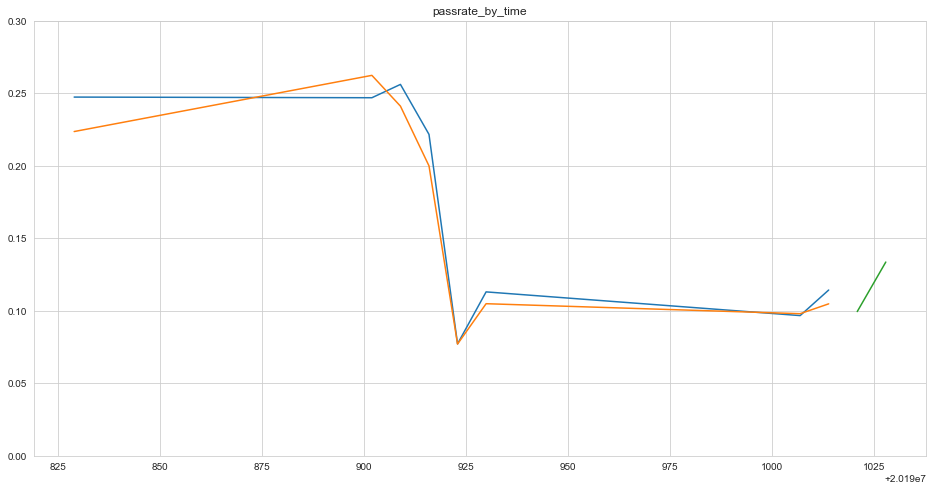

In [25]:
mm = df_var['day1'].unique().tolist()
mm.sort()
nn = [1,2,3]
plt.figure()
for i in nn:
    print(i)
    df_var1 = df_var[df_var['is_sample'] == i]
    frame1 = df_var1.groupby(['day1'])
    df_passrate = pd.DataFrame()
    df_passrate['count'] = frame1['loan_id'].count()
    df_passrate['pass_rate'] = frame1['flag_result'].sum()/df_passrate['count']
    df_passrate = df_passrate.reset_index()
    plt.plot(df_passrate['day1'], df_passrate['pass_rate'], label = str(i))
    plt.ylim(0,0.3)
plt.title( 'passrate_by_time' )

In [ ]:
mm = df_var['day1'].unique().tolist()
mm.sort()
var_list = feature_list

for var in var_list:
    print(var)
    color_list = ['r', 'g', 'b', 'y', 'c', 'm', 'y', 'k','gold', 'olive']
    fig= plt.figure(figsize = (4,4))
    for color1, week1 in zip(color_list, mm):
        df_var1 = df_var[df_var['day1'] == week1]
        sns.distplot(df_var1[var],color=color1)
    plt.title('Dist of %s' %var)
    plt.legend(labels = str(week1))
    plt.grid()
    result_path = os.path.join(file_path_model, 'figure/DistPlot/')
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    fig.savefig(os.path.join(result_path,  var + '.png'), format='png', dpi=300)
    plt.close()



cnt_app


Text(0.5, 1.0, 'Dist of cnt_app')

BB


Text(0.5, 1.0, 'Dist of BB')

Banco Inter


Text(0.5, 1.0, 'Dist of Banco Inter')

Empréstimo


Text(0.5, 1.0, 'Dist of Empréstimo')

Empréstimo Pessoal


Text(0.5, 1.0, 'Dist of Empréstimo Pessoal')

Google Play Games


Text(0.5, 1.0, 'Dist of Google Play Games')

Itaucard


Text(0.5, 1.0, 'Dist of Itaucard')

Itaú


Text(0.5, 1.0, 'Dist of Itaú')

Mercado Pago


Text(0.5, 1.0, 'Dist of Mercado Pago')

Messenger


Text(0.5, 1.0, 'Dist of Messenger')

Meu Vivo


Text(0.5, 1.0, 'Dist of Meu Vivo')

PagSeguro


Text(0.5, 1.0, 'Dist of PagSeguro')

Serasa


In [ ]:
def ContinuousBin(data_set, col, target, n, special_attribute ):
    data_bin = data_set[['loan_id','DATE', 'is_sample','flag_result', 'week', 'day1', col, target]].copy()
    data_bin = data_bin.fillna(-1)
    valueCounts = len((data_bin[col].unique()))
    if special_attribute != []:
        if list(set(data_bin[col])&set(special_attribute)):
            data_special = data_bin.loc[data_bin[col].isin(special_attribute)]
            data_special.loc[:, 'group'] = 'nan'
            data_bin = data_bin.loc[~data_bin[col].isin(special_attribute)]
            if valueCounts > n:
                data_bin.loc[:, 'group'] = pd.qcut(data_bin[col], n, duplicates='drop')
            else:
                data_bin.loc[:, 'group'] = data_bin[col]
            data_bin = pd.concat([data_special, data_bin], axis=0)
        else:
            if valueCounts > n:
                data_bin.loc[:, 'group'] = pd.qcut(data_bin[col], n, duplicates='drop')
            else:
                data_bin.loc[:, 'group'] = data_bin[col]
    else:
        if valueCounts > n:
            data_bin.loc[:, 'group'] = pd.qcut(data_bin[col], n, duplicates='drop')
        else:
            data_bin.loc[:, 'group'] = data_bin[col]
#     data_bin.rename(columns = {'group': col})
    return data_bin[['loan_id','DATE', 'is_sample', 'flag_result','week', 'day1','group']]

In [ ]:
import datetime
import seaborn as sns
feature = pd.read_csv(file_path_model + "features_in_model.csv")
feature.shape
feature_list = feature['var'].tolist()
df_var = pd.read_csv(file_path_in + 'df_var.csv')
df_var.shape
df_var['week'] = df_var['DATE'].apply(lambda x: datetime.datetime.strptime(str(x),'%Y%m%d').strftime('%W'))
group = df_var.groupby('week')
fram1 = pd.DataFrame()
fram1['day1'] = group['DATE'].min()
frame1 = fram1.reset_index()
week_dict = dict(zip(frame1['week'],frame1['day1'] ))
df_var['day1']= df_var['week'].apply(lambda x: week_dict[x]) 

In [ ]:
frame1 = pd.DataFrame()
var_list = feature_list
for var in var_list:
    print(var_list.index(var), var)
    mm = ContinuousBin(data_set = df_var.copy(), col = var, target = 'flag_result', n = 10, special_attribute = [-1])
    mm1 = pd.pivot_table(mm, index = 'group', columns='day1' ,values='loan_id',aggfunc = ['count'], fill_value=0)
    mm2 = mm1.div(mm1.sum(), axis=1)
    frame1 = frame1.append(mm2.reset_index())
    f, ax = plt.subplots(figsize = (10,10))
    pt = mm2 
    sns.heatmap(pt,annot=True, fmt='.2f', cbar = False)
    ax.set_title(var + '  map')
    result_path = os.path.join(file_path_model, 'figure/var_dist_bytime/')
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    f.savefig(os.path.join(result_path, var + '.png'), format='png', dpi=80)
    plt.close()
    
frame1.to_csv(file_path_model + 'var_dist_bytime.csv') 